# Incidence of chickenpox in France

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os.path
from os import path

The data on the incidence of chickenpox are available from the Web site of the [Réseau Sentinelles](http://www.sentiweb.fr/). We download them as a file in CSV format, in which each line corresponds to a week in the observation period. Only the complete dataset, starting in 1991 and ending with a recent week, is available for download.

In [3]:
if not path.exists("data.csv"):
    !wget http://www.sentiweb.fr/datasets/incidence-PAY-7.csv -O data.csv

--2022-10-28 18:36:11--  http://www.sentiweb.fr/datasets/incidence-PAY-7.csv
Resolving www.sentiweb.fr (www.sentiweb.fr)... 134.157.220.17
Connecting to www.sentiweb.fr (www.sentiweb.fr)|134.157.220.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73335 (72K) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>]  71.62K  --.-KB/s    in 0.02s   

2022-10-28 18:36:11 (3.42 MB/s) - ‘data.csv’ saved [73335/73335]



This is the documentation of the data from [the download site](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

| Column name  | Description                                                                                                               |
|--------------|---------------------------------------------------------------------------------------------------------------------------|
| `week`       | ISO8601 Yearweek number as numeric (year times 100 + week nubmer)                                                               |
| `indicator`  | Unique identifier of the indicator, see metadata document https://www.sentiweb.fr/meta.json                               |
| `inc`        | Estimated incidence value for the time step, in the geographic level                                                      |
| `inc_low`    | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc_up`     | Upper bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc100`     | Estimated rate incidence per 100,000 inhabitants                                                                          |
| `inc100_low` | Lower bound of the estimated incidence 95% Confidence Interval                                                            |
| `inc100_up`  | Upper bound of the estimated rate incidence 95% Confidence Interval                                                       |
| `geo_insee`  | Identifier of the geographic area, from INSEE https://www.insee.fr                                                        |
| `geo_name`   | Geographic label of the area, corresponding to INSEE code. This label is not an id and is only provided for human reading |

The first line of the CSV file is a comment, which we ignore with `skip=1`.

In [4]:
raw_data = pd.read_csv("data.csv", encoding = 'iso-8859-1', skiprows=1)
raw_data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202242,7,3450,1419,5481,5,2,8,FR,France
1,202241,7,4125,2177,6073,6,3,9,FR,France
2,202240,7,4883,1472,8294,7,2,12,FR,France
3,202239,7,2041,331,3751,3,0,6,FR,France
4,202238,7,1771,419,3123,3,1,5,FR,France
...,...,...,...,...,...,...,...,...,...,...
1659,199101,7,15565,10271,20859,27,18,36,FR,France
1660,199052,7,19375,13295,25455,34,23,45,FR,France
1661,199051,7,19080,13807,24353,34,25,43,FR,France
1662,199050,7,11079,6660,15498,20,12,28,FR,France


Are there missing data points? No, all weeks have observed values.

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name


~We delete this point, which does not have big consequence for our rather simple analysis.~

There's no incomplete data to delete

In [6]:
# data = raw_data.dropna().copy()
data = raw_data.copy()
data

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202242,7,3450,1419,5481,5,2,8,FR,France
1,202241,7,4125,2177,6073,6,3,9,FR,France
2,202240,7,4883,1472,8294,7,2,12,FR,France
3,202239,7,2041,331,3751,3,0,6,FR,France
4,202238,7,1771,419,3123,3,1,5,FR,France
...,...,...,...,...,...,...,...,...,...,...
1659,199101,7,15565,10271,20859,27,18,36,FR,France
1660,199052,7,19375,13295,25455,34,23,45,FR,France
1661,199051,7,19080,13807,24353,34,25,43,FR,France
1662,199050,7,11079,6660,15498,20,12,28,FR,France


Our dataset uses an uncommon encoding; the week number is attached
to the year number, leaving the impression of a six-digit integer.
That is how Pandas interprets it.

A second problem is that Pandas does not know about week numbers.
It needs to be given the dates of the beginning and end of the week.
We use the library `isoweek` for that.

Since the conversion is a bit lengthy, we write a small Python 
function for doing it. Then we apply it to all points in our dataset. 
The results go into a new column 'period'.

In [7]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

There are two more small changes to make.

First, we define the observation periods as the new index of
our dataset. That turns it into a time series, which will be
convenient later on.

Second, we sort the points chronologically.

In [8]:
sorted_data = data.set_index('period').sort_index()

We check the consistency of the data. Between the end of a period and
the beginning of the next one, the difference should be zero, or very small.
We tolerate an error of one second.

This is OK ~except for one pair of consecutive periods between which
a whole week is missing.~

~We recognize the dates: it's the week without observations that we
have deleted earlier!~

In [33]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

A first look at the data!

<AxesSubplot: xlabel='period'>

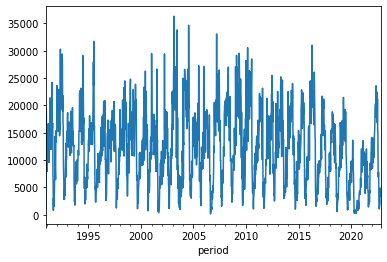

In [34]:
sorted_data['inc'].plot()

A zoom on the last few years shows more clearly that the peaks are situated in winter.

<AxesSubplot: xlabel='period'>

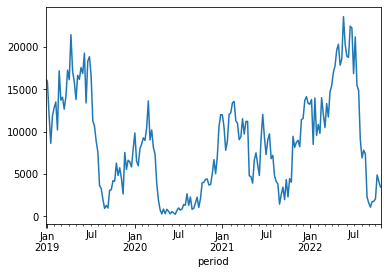

In [35]:
sorted_data['inc'][-200:].plot()

## Study of the annual incidence

Since the peaks of the epidemic happen in winter, near the transition
between calendar years, we define the reference period for the annual
incidence from August 1st of year $N$ to August 1st of year $N+1$. We
label this period as year $N+1$ because the peak is always located in
year $N+1$. The very low incidence in summer ensures that the arbitrariness
of the choice of reference period has no impact on our conclusions.

Our task is a bit complicated by the fact that a year does not have an
integer number of weeks. Therefore we modify our reference period a bit:
instead of August 1st, we use the first day of the week containing August 1st.

A final detail: the dataset starts in December 1990, the first peak is thus
incomplete, We start the analysis with the first full peak.

In [28]:
first_august_week = [pd.Period(pd.Timestamp(y, 8, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

Starting from this list of weeks that contain August 1st, we obtain intervals of approximately one year as the periods between two adjacent weeks in this list. We compute the sums of weekly incidences for all these periods.

We also check that our periods contain between 51 and 52 weeks, as a safeguard against potential mistakes in our code.

In [29]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

And here are the annual incidences.

<AxesSubplot: >

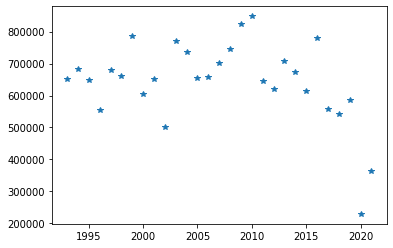

In [30]:
yearly_incidence.plot(style='*')

A sorted list makes it easier to find the highest values (at the end).

In [31]:
yearly_incidence.sort_values()

2020    229363
2021    363278
2002    502271
2018    543281
1996    553859
2017    557449
2019    584926
2000    605096
2015    613286
2012    620315
2011    645042
1995    648598
2001    650660
1993    653058
2005    654308
2006    657482
1998    660316
2014    673458
1997    679308
1994    682920
2007    701566
2013    708874
2004    736266
2008    745701
2003    770211
2016    780645
1999    784963
2009    822819
2010    848236
dtype: int64

The final histogram shows that in more than 20 different years the epidemic affected more than 600k people and in 2 years more than 800k.

<AxesSubplot: >

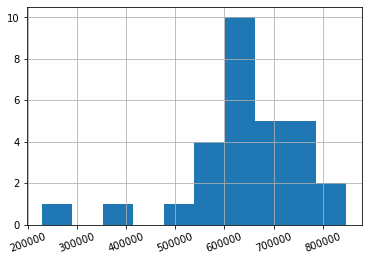

In [32]:
yearly_incidence.hist(xrot=20)